# CIFAR10-embeddings dataset 

In [1]:
import sys

sys.path.append('/home/caihuaiguang/DSG/opendataval')
# 验证路径是否已添加
print(sys.path)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 


['/media/caihuaiguang/miniconda3/envs/open/lib/python39.zip', '/media/caihuaiguang/miniconda3/envs/open/lib/python3.9', '/media/caihuaiguang/miniconda3/envs/open/lib/python3.9/lib-dynload', '', '/media/caihuaiguang/miniconda3/envs/open/lib/python3.9/site-packages', '/home/caihuaiguang/DSG/opendataval']


In [2]:
# Imports
import numpy as np
import pandas as pd
import torch

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceSubsample,
    CHGShapley,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator

[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors compiling formula :
In file included from /media/caihuaiguang/miniconda3/envs/open/lib/python3.9/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:21:0:
/media/caihuaiguang/miniconda3/envs/open/lib/python3.9/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp: In function ‘int Compile(const char*, const char*, int, int, const char*)’:
/media/caihuaiguang/miniconda3/envs/open/lib/python3.9/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:90:57: error: ‘nvrtcGetCUBINSize’ was not declared in this scope
     NVRTC_SAFE_CALL(nvrtcGetTARGETSize(prog, &targetSize));
                                                         ^
/media/caihuaiguang/miniconda3/envs/open/lib/python3.9/site-packages/keopscore/include/utils_pe.h:6:26: note: in definition of macro ‘NVRTC_SAFE_CALL’
     nvrtcResult result = x;                                       \
                          ^
/media/caihuaiguang/minic

/media/caihuaiguang/miniconda3/envs/open/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: CIFAR10-embeddings
- Model: Pretrained ResNet50 + LogisticRegression
- Metric: Classification accuracy

In [3]:
dataset_name = "cifar10-embeddings"
train_count, valid_count, test_count = 1000, 100, 300
noise_rate = 0.1
noise_kwargs = {'noise_rate': noise_rate}
model_name = "LogisticRegression" # will train a logistic regression model built with PyTorch (sklearn's logistic regression can be very slow).
metric_name = "accuracy"
train_kwargs = {"epochs": 10, "batch_size": 100, "lr": 0.01}
# device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda:0' 
exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=mix_labels,
    noise_kwargs=noise_kwargs,
    train_kwargs=train_kwargs,
    model_name=model_name,
    metric_name=metric_name
)

Base line model metric_name='accuracy': perf=0.653333306312561


## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [4]:
data_evaluators = [ 
    CHGShapley(),
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceSubsample(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
    # DataShapley(cache_name=f"cached"), # Data-Shapley ## slow
    # BetaShapley(cache_name=f"cached"), # Beta-Shapley ## slow
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
]

In [5]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time CHGShapley(): 0:00:18.229570
Elapsed time RandomEvaluator(): 0:00:00.000982


100%|██████████| 1000/1000 [1:41:17<00:00,  6.08s/it]


Elapsed time LeaveOneOut(): 1:41:25.178555


100%|██████████| 1000/1000 [1:11:42<00:00,  4.30s/it]


Elapsed time InfluenceSubsample(num_models=1000): 1:11:42.687064


100%|██████████| 2000/2000 [05:53<00:00,  5.66it/s]
/media/caihuaiguang/miniconda3/envs/open/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3103: UserWarning: 
                    An error occured during training, however training all evaluators
                    takes a long time, so we will be ignoring the evaluator:
                    KNNShapley(k_neighbors=100) and proceeding.

                    The error is as follows: 'Subset' object has no attribute 'view'
                    
  result = runner(coro)


Elapsed time DVRL(rl_epochs=2000): 0:06:10.759454


100%|██████████| 1000/1000 [1:04:06<00:00,  3.85s/it]


Elapsed time DataBanzhaf(num_models=1000): 1:04:06.514354


100%|██████████| 1000/1000 [1:40:21<00:00,  6.02s/it]


Elapsed time AME(num_models=1000): 4:38:19.484000


100%|██████████| 1000/1000 [2:02:03<00:00,  7.32s/it] 


Elapsed time DataOob(num_models=1000): 2:02:03.674421


Elapsed time LavaEvaluator(): 0:00:02.017117
CPU times: user 2d 21h 35min 34s, sys: 4h 35min 24s, total: 3d 2h 10min 58s
Wall time: 10h 44min 8s


## [Step 3] Evaluate data values

In [6]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/cifar10-embeddings_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [7]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.181989
CHGShapley(),0.334405
DVRL(rl_epochs=2000),0.297872
DataBanzhaf(num_models=1000),0.160883
DataOob(num_models=1000),0.368821
InfluenceSubsample(num_models=1000),0.199662
LavaEvaluator(),0.212329
LeaveOneOut(),0.184573
RandomEvaluator(),0.173623


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

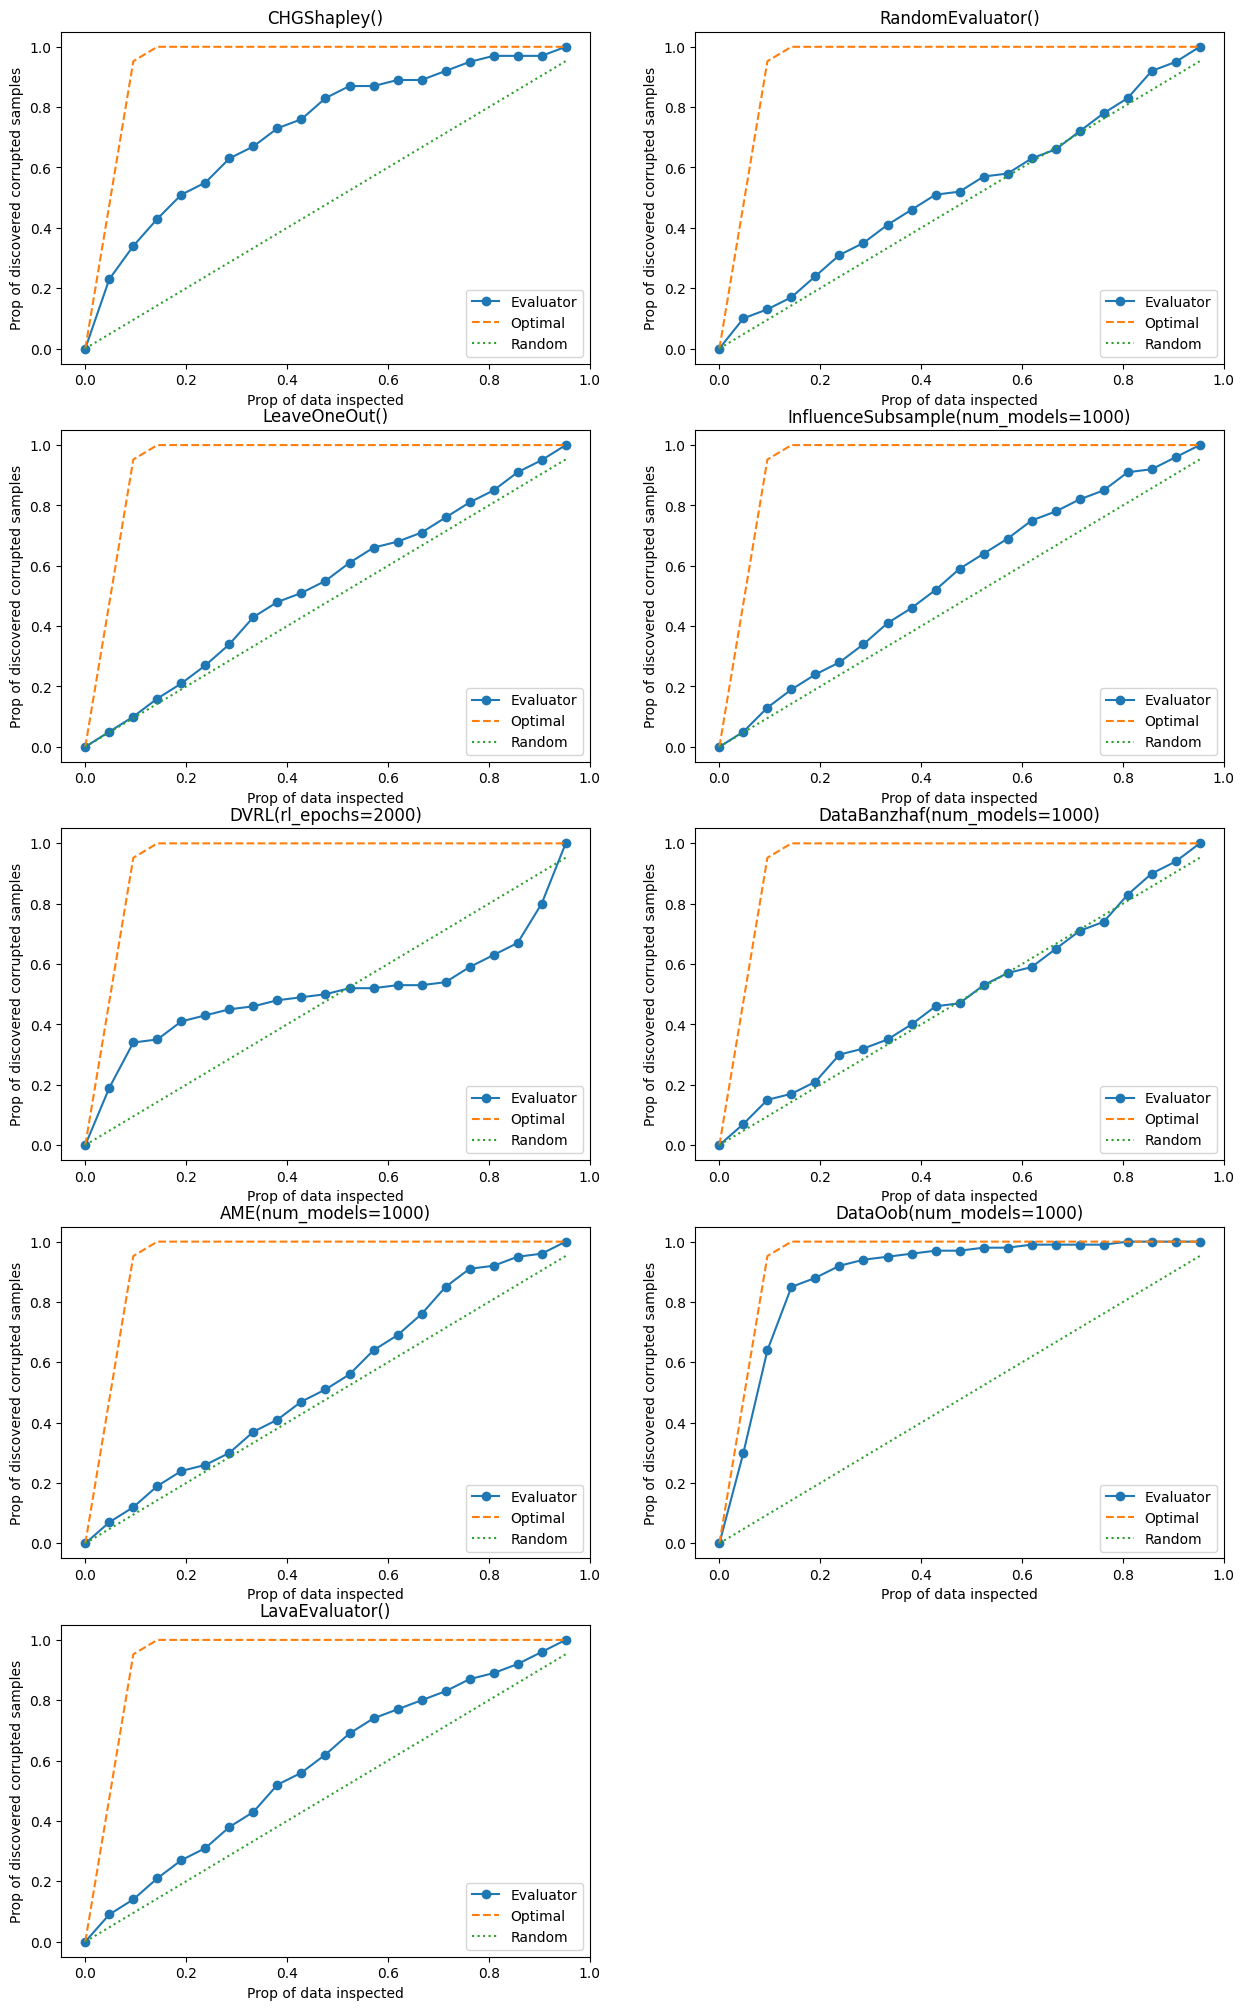

In [8]:
fig = plt.figure(figsize=(15, 25))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

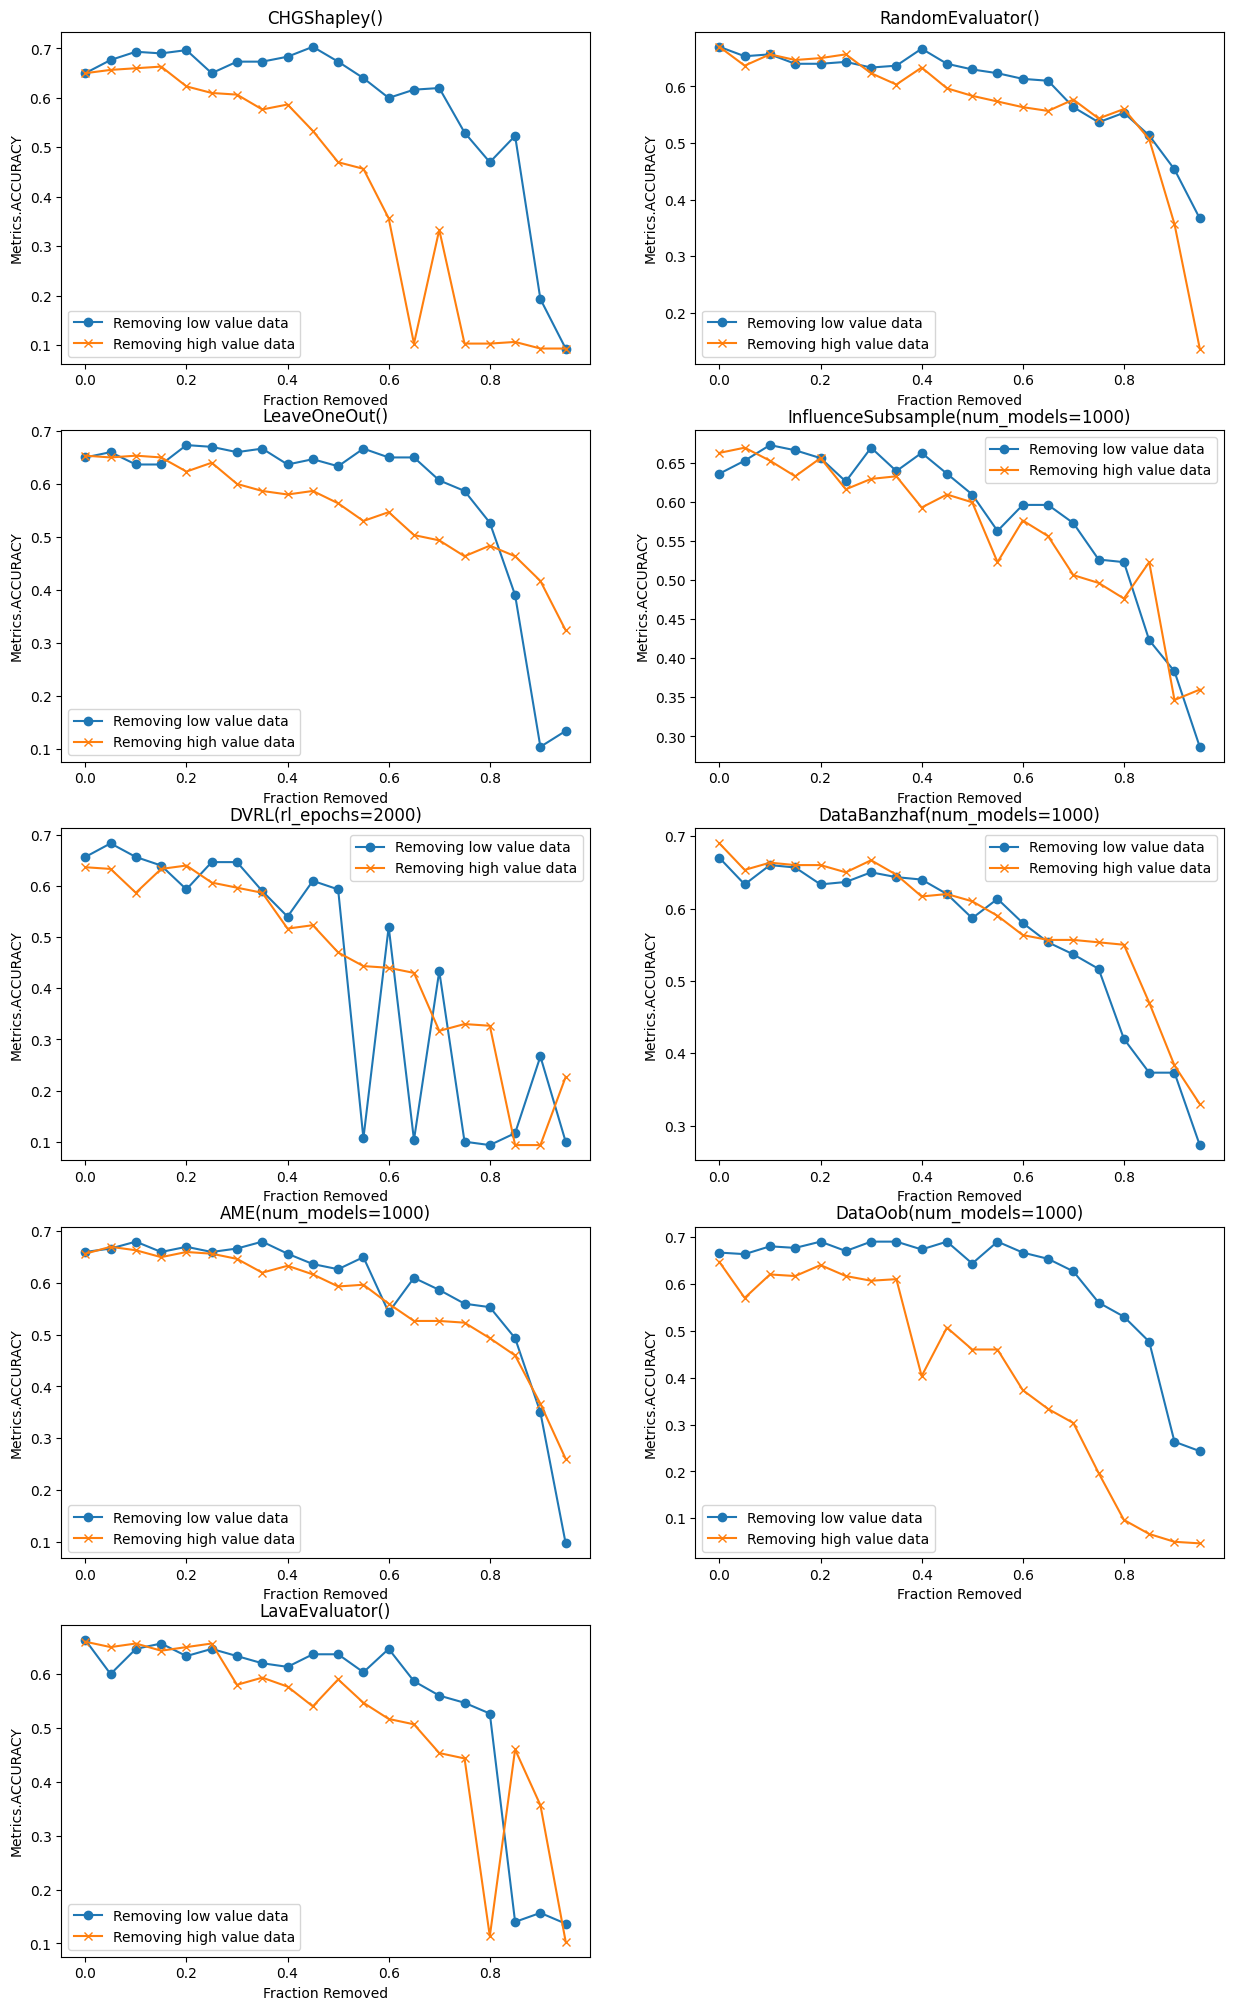

In [9]:
fig = plt.figure(figsize=(15, 25))
df_resp, fig = exper_med.plot(remove_high_low, fig, col=2, save_output=True)

In [10]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.ACCURACY,remove_most_influential_first_Metrics.ACCURACY,axis
CHGShapley(),0.65,0.65,0.0
CHGShapley(),0.676667,0.656667,0.05
CHGShapley(),0.693333,0.66,0.1
CHGShapley(),0.69,0.663333,0.15
CHGShapley(),0.696667,0.623333,0.2
...,...,...,...
LavaEvaluator(),0.546667,0.443333,0.75
LavaEvaluator(),0.526667,0.113333,0.8
LavaEvaluator(),0.14,0.46,0.85
LavaEvaluator(),0.156667,0.356667,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [11]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
CHGShapley(),48524,-0.000021
CHGShapley(),2694,0.000022
CHGShapley(),17614,-0.000068
CHGShapley(),27096,0.000002
CHGShapley(),33628,0.000028
...,...,...
LavaEvaluator(),14390,-19.879261
LavaEvaluator(),9132,-1.686199
LavaEvaluator(),5516,-0.894138
LavaEvaluator(),37327,11.672779
